## Summary

----

## Imports

In [1]:
import concurrent.futures
import io
import itertools
import math
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import torch
from IPython.display import SVG, Image, set_matplotlib_formats
from kmbio import PDB
from kmtools import structure_tools
from scipy import stats
from tqdm.notebook import tqdm

In [2]:
pd.set_option("max_columns", 1000)
pd.set_option("max_rows", 1000)

# set_matplotlib_formats("png")

In [3]:
%matplotlib inline

## Parameters

In [4]:
NOTEBOOK_NAME = "07_protein_analysis_figures"
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).resolve(strict=True)
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_PATH

PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/07_protein_analysis_figures')

In [5]:
if "DATAPKG_OUTPUT_DIR" in os.environ:
    OUTPUT_DIR = Path(os.getenv("DATAPKG_OUTPUT_DIR")).joinpath("proteinsolver").resolve()
else:
    OUTPUT_DIR = NOTEBOOK_DIR.parent
OUTPUT_DIR.mkdir(exist_ok=True)

display(OUTPUT_DIR)

PosixPath('/home/kimlab1/database_data/datapkg_output_dir/proteinsolver')

## Functions

In [6]:
def add_diff(df, colname):
    if f"{colname}_wt" not in df:
        before_ = len(df)
        ext = ".pdb" if not df.iloc[0]["name"].endswith(".pdb") else ""
        row_is_wt = (df["name"] + ext) == df["my_wt"]
        assert set(df[row_is_wt]["my_wt"]) == set(df["my_wt"])
        df2 = df[row_is_wt][["my_wt", colname]].rename(columns={colname: f"{colname}_wt"})
        df = df.merge(df2, on="my_wt")
        assert before_ == len(df), (before_, len(df))
    df[f"{colname}_change"] = df[f"{colname}"] - df[f"{colname}_wt"]
    return df

In [7]:
def get_conf_interval(r, num):
    stderr = 1.0 / math.sqrt(num - 3)
    delta = 1.96 * stderr
    lower = math.tanh(math.atanh(r) - delta)
    upper = math.tanh(math.atanh(r) + delta)
    return r - lower, upper - r

In [8]:
def bootstrap_confidence_interval(
    values1, values2, fn, num_iterations=10_000, show_progress=True, seed=42
):
    rng = np.random.default_rng(seed)
    outputs = []
    for _ in tqdm(range(num_iterations), disable=not show_progress):
        index = rng.choice(len(values1), len(values1), replace=True)
        while len(np.unique(index)) == 1:
            index = rng.choice(len(values1), len(values1), replace=True)
        values1_sample = values1[index]
        values2_sample = values2[index]
        output = fn(values1_sample, values2_sample)
        outputs.append(output)
    lower = np.quantile(outputs, 0.05)
    upper = np.quantile(outputs, 0.95)
    return lower, upper, outputs

In [9]:
def compare_correlations(corrs_ref, corrs):
    num_greater = ((corrs_ref.reshape(-1, 1) - corrs.reshape(1, -1)) > 0).sum()
    num_any = len(corrs_ref) * len(corrs)
    return num_greater / num_any

In [10]:
# bootstrap_confidence_interval(
#     np.array([1, 2, 3, 4, 5]),
#     np.array([1, 2, 3, 5, 4]),
#     fn=lambda v1, v2: stats.spearmanr(v1, v2)[0],
# )

In [11]:
def parse_correlation_table(text, sep="|"):
    buf = io.StringIO()
    buf.write(text)
    buf.seek(0)
    df = pd.read_csv(buf, sep=sep)
    if "N" in df:
        df["corr_lower_bound"], df["corr_upper_bound"] = list(
            zip(*[get_conf_interval(corr, N) for corr, N in df[["corr", "N"]].values])
        )
        del df["N"]
    return df

In [12]:
def get_aa_sequence(structure_file):
    structure = PDB.load(structure_file)
    model_id = next(structure.models).id
    chain_id = next(structure.chains).id
    aa_sequence = structure_tools.extract_aa_sequence(structure, model_id, chain_id)
    return aa_sequence

In [13]:
def compute_ddg_correlation(
    my_wt, feature_column, target_column, df, return_corrs=False, show_progress=False,
):
    sign = 1 if feature_column in ["network_score_change", "scan_sm_log_change"] else -1
    df_notnull = df.dropna(subset=[target_column, feature_column])
    if len(df) > len(df_notnull):
        print(
            f"Removing {len(df) - len(df_notnull)} rows with null values for columns: "
            f"{[target_column, feature_column]}."
        )
        df = df_notnull
    values_ref = df[target_column].values
    values = sign * df[feature_column].values
    corr = stats.spearmanr(values_ref, values)
    lower, upper, corrs = bootstrap_confidence_interval(
        values_ref,
        values,
        fn=lambda v1, v2: stats.spearmanr(v1, v2)[0],
        show_progress=show_progress,
    )
    result = {
        "my_wt": my_wt,
        "feature": feature_column,
        "corr": corr[0],
        "pvalue": corr[1],
        "corr_lower_bound": lower,
        "corr_upper_bound": upper,
    }
    if return_corrs:
        result["corrs"] = corrs
    return result

In [14]:
def compute_stability_correlation(
    library, domain, feature_column, gp, return_corrs=False, show_progress=False,
):
    if "betanov" in feature_column or "talaris" in feature_column:
        values = (-gp[feature_column] / gp["sequence_length"]).values
    else:
        values = gp[feature_column].values
    values_ref = gp[["stabilityscore_t", "stabilityscore_c"]].mean(axis=1).values
    corr = stats.spearmanr(values_ref, values)
    lower, upper, corrs = bootstrap_confidence_interval(
        values_ref,
        values,
        fn=lambda v1, v2: stats.spearmanr(v1, v2)[0],
        show_progress=show_progress,
    )
    result = {
        "library": library,
        "domain": domain,
        "feature": feature_column,
        "corr": corr[0],
        "pvalue": corr[1],
        "corr_lower_bound": lower,
        "corr_upper_bound": upper,
    }
    if return_corrs:
        result["corrs"] = corrs
    return result

In [15]:
def get_superior_to_ps_string(pvalue, cutoff):
    if pd.isnull(pvalue):
        return ""
    elif pvalue < cutoff:
        return f"Superior (p = {pvalue:.4f})"
    elif pvalue > (1 - cutoff):
        return f"Inferior (p = {pvalue:.4f})"
    else:
        return f"No sig. diff. (p = {pvalue:.4f})"

## Load data

### Rosetta scores - Protherm

In [16]:
get_aa_sequence(
    "/home/kimlab1/strokach/workspace/adjacency-net-v2/notebooks/01_protherm_dataset/structures/pdb107l.entA_0--G44S-wt.pdb"
)

'MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKGELDKAIGRNTNGVITKDEAEKLFNQDVDAAVRGILRNAKLKPVYDSLDAVRRAALINMVFQMGETGVAGFTNSLRMLQQKRWDEAAVNLAKSRWYNQTPNRAKRVITTFRTGTWDAYK'

In [17]:
!ls /home/kimlab1/strokach/workspace/adjacency-net-v2/notebooks/01_protherm_dataset/structures/ | head -n 2

pdb107l.entA_0--G44S-wt.pdb
pdb160l.entA_0--A120M-wt.pdb
ls: write error: Broken pipe


In [18]:
STRUCTURES_PATH = Path(
    "/home/kimlab1/strokach/workspace/adjacency-net-v2/notebooks/01_protherm_dataset/structures/"
).resolve(strict=True)
STRUCTURES_PATH

PosixPath('/home/kimlab1/strokach/workspace/adjacency-net-v2/notebooks/01_protherm_dataset/structures')

In [19]:
protherm_design_rue = pd.read_csv(NOTEBOOK_PATH.joinpath("protherm_design_wt_RUE.csv"), index_col=0)

#### Average out energies of wild-type structures

In [20]:
protherm_design_rue["filename_prefix"] = protherm_design_rue["filename"].str.split("-").str[0]

In [21]:
filename_prefix_to_reu_wt = {}
for filename_prefix, gp in protherm_design_rue.groupby("filename_prefix"):
    filename_prefix_to_reu_wt[filename_prefix] = gp["RUE_wt"].mean()
print(len(filename_prefix_to_reu_wt))

179


In [22]:
protherm_design_rue["RUE_wt_2"] = protherm_design_rue["filename_prefix"].map(
    filename_prefix_to_reu_wt
)

In [23]:
protherm_design_rue["rosetta_reu_change"] = (
    protherm_design_rue["RUE_mut"] - protherm_design_rue["RUE_wt_2"]
)

In [24]:
stats.spearmanr(protherm_design_rue["rosetta_reu_change"], protherm_design_rue["ddg_exp"])

SpearmanrResult(correlation=-0.008007305189965822, pvalue=0.6372197700858309)

#### Normalize by sequence length

In [25]:
try:
    protherm_design_rue["sequence_length"] = torch.load(
        NOTEBOOK_PATH.joinpath("protherm-sequence-lengths.torch")
    )
except FileNotFoundError:
    sequence_lengths = [
        len(get_aa_sequence(STRUCTURES_PATH.joinpath(s)))
        for s in tqdm(protherm_design_rue["filename"].values)
    ]
    torch.save(sequence_lengths, NOTEBOOK_PATH.joinpath("protherm-sequence-lengths.torch"))
    protherm_design_rue["sequence_length"] = sequence_lengths

In [26]:
protherm_design_rue["rosetta_reu_norm_change"] = (
    protherm_design_rue["rosetta_reu_change"] / protherm_design_rue["sequence_length"]
)

In [27]:
stats.spearmanr(protherm_design_rue["rosetta_reu_norm_change"], protherm_design_rue["ddg_exp"])

SpearmanrResult(correlation=0.08262914198402263, pvalue=1.0897621694155652e-06)

In [28]:
protherm_design_rue.head()

,filename,chain_id,mutation,ddg_exp,RUE_mut,wt_aa,pos,mut,RUE_wt,filename_prefix,RUE_wt_2,rosetta_reu_change,sequence_length,rosetta_reu_norm_change
0,pdb107l.entA_0--G44S-wt.pdb,A,G44S,-0.53,-165.203,G,44,S,-342.526,pdb107l.entA_0,-342.526,177.323,162,1.094586
1,pdb160l.entA_0--A120M-wt.pdb,A,A120M,-0.20,-136.290,A,120,M,-351.957,pdb160l.entA_0,-351.957,215.667,162,1.331278
2,pdb161l.entA_0--A116N-wt.pdb,A,A116N,0.17,-147.909,A,116,N,-360.530,pdb161l.entA_0,-360.530,212.621,162,1.312475
3,pdb162l.entA_0--A122Q-wt.pdb,A,A122Q,-0.24,-177.392,A,122,Q,-365.948,pdb162l.entA_0,-365.948,188.556,162,1.163926
4,pdb163l.entA_0--A123Q-wt.pdb,A,A123Q,-0.22,-170.658,A,123,Q,-345.064,pdb163l.entA_0,-345.064,174.406,162,1.076580


### Protherm

In [29]:
protherm_wresults_df = torch.load(
    NOTEBOOK_PATH.parent.joinpath("protein_analysis", "protherm_wresults.torch")
)
protherm_wresults_df["ddg_exp"] = -protherm_wresults_df["ddg_exp"]

In [30]:
# Rosetta scores
assert (protherm_wresults_df["mutation"] == protherm_design_rue["mutation"]).all()

protherm_wresults_df["rosetta_reu_change"] = protherm_design_rue["rosetta_reu_change"].values
protherm_wresults_df["rosetta_reu_norm_change"] = protherm_design_rue[
    "rosetta_reu_norm_change"
].values

In [31]:
protherm_has_homologs = pq.read_table(
    NOTEBOOK_PATH.parents[2].joinpath(
        "neurips19-graph-protein-design",
        "notebooks",
        "02_protherm_remote_subset",
        "protherm-has-homologs.parquet",
    )
).to_pandas(integer_object_nulls=True)

protherm_wresults_df["has_homologs"] = (
    protherm_wresults_df.set_index(["structure_id", "chain_id"]).index
).map(protherm_has_homologs.set_index(["pdb_id", "pdb_chain"])["has_homologs_35"])

In [32]:
# Ingraham network predictions
ingraham_df = pq.read_table(
    NOTEBOOK_PATH.parents[2].joinpath(
        "neurips19-graph-protein-design",
        "notebooks",
        "02_predict_mutation_effect",
        "protherm_mutation.parquet",
    )
).to_pandas(integer_object_nulls=True)

ingraham_df["pdb_id"], ingraham_df["pdb_chain"] = list(zip(*ingraham_df["name"].str.split("-")))

unique_mutations = set(tuple(t) for t in ingraham_df[["pdb_id", "pdb_chain", "mutation"]].values)
unique_known_mutations = set(
    tuple(t) for t in protherm_wresults_df[["structure_id", "chain_id", "mutation"]].values
)
print(f"Failed to match {len(unique_mutations -unique_known_mutations)} mutations.")
print(f"Missing {len(unique_known_mutations - unique_mutations)} mutations.")

protherm_wresults_df["ingraham_neglogp_change"] = (
    protherm_wresults_df.set_index(["structure_id", "chain_id", "mutation"]).index
).map(ingraham_df.set_index(["pdb_id", "pdb_chain", "mutation"])["neglogp_change"])

Failed to match 163 mutations.
Missing 98 mutations.


### GAPF - Mutations

In [33]:
MUTATION_METHOD = "logproba.scan"

In [34]:
stability_scores_for_mutations = torch.load(
    NOTEBOOK_PATH.parent.joinpath(
        "06_global_analysis_of_protein_folding",
        f"stability_scores_for_mutations.{MUTATION_METHOD}.torch",
    )
)

In [35]:
# Rosetta energy function scores
carles_rosetta_scores_df = pd.read_csv(NOTEBOOK_PATH.joinpath("GAPF_design_RUE_wt.csv"))
carles_rosetta_scores_df["rosetta_score_change"] = (
    carles_rosetta_scores_df["RUE"] - carles_rosetta_scores_df["RUE_wt"]
)

stability_scores_for_mutations["ssm2"]["rosetta_score_change"] = (
    stability_scores_for_mutations["ssm2"]
    .set_index(["my_wt", "pos", "wt_aa", "mut", "sequence"])
    .index.map(
        carles_rosetta_scores_df.set_index(["my_wt", "pos", "wt_aa", "mut", "sequence"])[
            "rosetta_score_change"
        ]
    )
)

In [36]:
# Ingraham network predictions
ingraham_df = pq.read_table(
    NOTEBOOK_PATH.parents[2].joinpath(
        "neurips19-graph-protein-design",
        "notebooks",
        "02_predict_mutation_effect",
        "rocklin_2017_mutation_ssm2.parquet",
    )
).to_pandas(integer_object_nulls=True)

(
    stability_scores_for_mutations["ssm2"]["ingraham_neglogp_change"]
) = stability_scores_for_mutations["ssm2"]["sequence"].map(
    ingraham_df.set_index("mut_seq")["neglogp_change"]
)

In [37]:
def adjust_name(name):
    if name.startswith("Pin1"):
        prot, mut = name.split("_")
        mut = f"{mut[0]}{int(mut[1:-1]) - 1}{mut[-1]}"
        return f"{prot}_{mut}"
    elif name.startswith("villin"):
        prot, mut = name.split("_")
        mut = f"{mut[0]}{int(mut[1:-1]) - 5}{mut[-1]}"
        return f"{prot}_{mut}"
    else:
        return name

In [38]:
# Rosetta's ddg_monomer
cartesian_ddg_df = pq.read_table(
    OUTPUT_DIR.parent.joinpath("tkpod-rosetta-ddg", "rocklin_2017_ssm2_cartesian_ddg.parquet")
).to_pandas(integer_object_nulls=True)
cartesian_ddg_df["name"] = cartesian_ddg_df["name"] + "_" + cartesian_ddg_df["mutation"]
cartesian_ddg_df["name"] = cartesian_ddg_df["name"].apply(adjust_name).values

assert not set(cartesian_ddg_df["name"]) - set(stability_scores_for_mutations["ssm2"]["name"])

stability_scores_for_mutations["ssm2"]["cartesian_ddg_change"] = (
    stability_scores_for_mutations["ssm2"]["name"]
).map(cartesian_ddg_df.set_index("name")["dg_change"])

In [39]:
# Rosetta's cartesian_ddg
ddg_monomer_dg = pq.read_table(
    OUTPUT_DIR.parent.joinpath("tkpod-rosetta-ddg", "rocklin_2017_ssm2_ddg_monomer.parquet")
).to_pandas(integer_object_nulls=True)
ddg_monomer_dg["name"] = ddg_monomer_dg["name"] + "_" + ddg_monomer_dg["mutation"]
ddg_monomer_dg["name"] = ddg_monomer_dg["name"].apply(adjust_name)

assert not set(ddg_monomer_dg["name"]) - set(stability_scores_for_mutations["ssm2"]["name"])

stability_scores_for_mutations["ssm2"]["ddg_monomer_change"] = (
    stability_scores_for_mutations["ssm2"]["name"]
).map(ddg_monomer_dg.set_index("name")["dg_change"])

In [40]:
stability_scores_for_mutations["ssm2"].describe()

,pos,ec50_t,delta_ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,delta_pred_vs_wt_t,ec50_rise_t,stabilityscore_t,ec50_c,delta_ec50_c,ec50_95ci_lbound_c,ec50_95ci_ubound_c,ec50_95ci_c,ec50_pred_c,delta_pred_vs_wt_c,ec50_rise_c,stabilityscore_c,ec50_rise_c_adj,stabilityscore_c_adj,consensus_ec50_rise,consensus_stability_score,network_score,rosetta_score_change,ingraham_neglogp_change,cartesian_ddg_change,ddg_monomer_change
count,12851.000000,12851.000000,12851.000000,12851.000000,12851.000000,12851.000000,12851.000000,12851.000000,12851.00000,12851.000000,12851.000000,12851.000000,12851.000000,12851.000000,12851.000000,12851.000000,12851.000000,12851.000000,12851.000000,12851.000000,12851.000000,12851.000000,12851.000000,9913.000000,9900.00000,10674.000000,10674.000000,10674.000000
mean,21.510077,3.558901,-0.911788,3.419096,3.734309,0.315213,-1.257221,0.018486,4.81615,1.449826,2.572824,-0.589170,2.414310,2.774313,0.360003,-0.755856,0.006494,3.328778,1.002042,3.330559,1.002575,3.500066,1.053593,-81.464641,60.61660,0.061666,4.626575,3.026326
std,12.232652,1.529182,1.394367,1.550756,1.474168,0.255741,1.040099,0.349419,2.03009,0.611108,1.152953,0.860679,1.170877,1.118192,0.305776,0.787102,0.360246,1.357631,0.408728,1.354769,0.407864,1.322078,0.398012,16.119577,78.36315,0.049345,7.498591,9.581338
min,0.000000,-1.070000,-5.730000,-0.500000,-0.400000,0.000000,-3.770000,-2.570000,-2.06000,-0.620000,-0.790000,-4.580000,-0.500000,-0.500000,0.000000,-2.820000,-2.160000,-0.880000,-0.270000,-0.880000,-0.270000,-0.870000,-0.260000,-132.226303,11.53400,-0.104663,-11.788000,-8.990000
25%,11.000000,2.540000,-1.730000,2.400000,2.700000,0.200000,-1.760000,-0.050000,3.36000,1.010000,1.940000,-0.950000,1.800000,2.200000,0.200000,-1.250000,-0.070000,2.460000,0.740000,2.470000,0.740000,2.570000,0.770000,-89.816566,21.30825,0.026294,0.405500,-0.401000
50%,21.000000,4.510000,-0.130000,4.300000,4.700000,0.300000,-1.160000,-0.000000,5.28000,1.590000,2.770000,-0.320000,2.600000,3.000000,0.300000,-0.850000,0.000000,3.310000,1.000000,3.310000,1.000000,3.490000,1.050000,-76.851799,25.94650,0.059815,2.402000,1.611500
75%,32.000000,4.660000,0.010000,4.600000,4.800000,0.400000,-0.490000,0.070000,6.25000,1.880000,3.520000,0.000000,3.400000,3.700000,0.500000,-0.200000,0.060000,4.170000,1.260000,4.170000,1.260000,4.370000,1.320000,-69.900856,86.10625,0.099222,6.178500,4.504750
max,46.000000,7.470000,2.880000,6.100000,6.500000,6.800000,1.670000,2.630000,8.79000,2.650000,6.600000,2.890000,6.500000,8.500000,9.000000,2.700000,2.640000,8.840000,2.660000,8.840000,2.660000,8.280000,2.490000,-54.083675,2097.36100,0.249719,99.926667,188.960000


#### Format `ssm2`

In [41]:
stability_scores_for_mutations["ssm2"]["consensus_stability_score2"] = (
    stability_scores_for_mutations["ssm2"]["stabilityscore_t"]
    + stability_scores_for_mutations["ssm2"]["stabilityscore_c"]
) / 2

In [42]:
for column in [
    "network_score",
    "stabilityscore_t",
    "stabilityscore_c",
    "consensus_stability_score",
    "consensus_stability_score2",
]:
    stability_scores_for_mutations["ssm2"] = add_diff(
        stability_scores_for_mutations["ssm2"], column
    )

In [43]:
display(stability_scores_for_mutations["ssm2"].head(2))

,name,sequence,my_wt,pos,mut,wt_aa,ec50_t,delta_ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,delta_pred_vs_wt_t,ec50_rise_t,stabilityscore_t,ec50_c,delta_ec50_c,ec50_95ci_lbound_c,ec50_95ci_ubound_c,ec50_95ci_c,ec50_pred_c,delta_pred_vs_wt_c,ec50_rise_c,stabilityscore_c,ec50_rise_c_adj,stabilityscore_c_adj,consensus_ec50_rise,consensus_stability_score,library_name,network_score,rosetta_score_change,ingraham_neglogp_change,cartesian_ddg_change,ddg_monomer_change,consensus_stability_score2,network_score_wt,network_score_change,stabilityscore_t_wt,stabilityscore_t_change,stabilityscore_c_wt,stabilityscore_c_change,consensus_stability_score_wt,consensus_stability_score_change,consensus_stability_score2_wt,consensus_stability_score2_change
0,EEHEE_rd3_0037.pdb,TTIKVNGQEYTVPLSPEQAAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,0,na,wt,4.67,0.00,4.7,4.7,0.0,-1.02,0.00,5.69,1.71,3.33,0.00,3.3,3.3,0.0,0.51,0.0,2.83,0.85,2.83,0.85,2.83,0.85,ssm2,-80.553299,NaN,NaN,NaN,NaN,1.28,-80.553299,0.000000,1.71,0.00,0.85,0.00,0.85,0.00,1.28,0.00
1,EEHEE_rd3_0037.pdb_A19D,TTIKVNGQEYTVPLSPEQDAKAAKKRWPDYEVQIHGNTVKVTR,EEHEE_rd3_0037.pdb,19,D,A,-0.40,-5.07,-0.5,-0.3,0.2,-0.87,0.15,0.47,0.14,1.81,-1.52,1.7,1.9,0.2,0.81,0.3,1.00,0.30,1.00,0.30,0.99,0.30,ssm2,-88.784714,51.13,0.109372,20.296,9.879,0.22,-80.553299,-8.231415,1.71,-1.57,0.85,-0.55,0.85,-0.55,1.28,-1.06


In [44]:
missing_reu_df = stability_scores_for_mutations["ssm2"][
    stability_scores_for_mutations["ssm2"]["rosetta_score_change"].isnull()
]

In [45]:
len(missing_reu_df)

2951

In [46]:
(missing_reu_df["pos"] != 0).sum()

2934

In [47]:
(missing_reu_df["mut"] != "na").sum()

2934

#### Format `fig1`

In [48]:
stability_scores_for_mutations["fig1"] = stability_scores_for_mutations["fig1"].rename(
    columns={"deltaGunf thermal": "dg_thermal", "deltaGunf chemical": "dg_chemical"}
)

stability_scores_for_mutations["fig1"]["consensus_stability_score"] = (
    stability_scores_for_mutations["fig1"]["stabilityscore_t"]
    + stability_scores_for_mutations["fig1"]["stabilityscore_c"]
) / 2

stability_scores_for_mutations["fig1"]["consensus_dg"] = (
    stability_scores_for_mutations["fig1"]["dg_thermal"]
    + stability_scores_for_mutations["fig1"]["dg_chemical"]
) / 2

In [49]:
for column in [
    "network_score",
    "stabilityscore_t",
    "stabilityscore_c",
    "consensus_stability_score",
    "dg_thermal",
    "dg_chemical",
    "consensus_dg",
    "Tm",
]:
    stability_scores_for_mutations["fig1"] = add_diff(
        stability_scores_for_mutations["fig1"], column
    )

### GAPF - Stability

In [50]:
STABILITY_METHOD = "logproba.incremental"  # "logproba.randmask50"

In [51]:
stability_scores_for_designs = torch.load(
    NOTEBOOK_PATH.parent.joinpath(
        "06_global_analysis_of_protein_folding",
        f"stability_scores_for_selections.{STABILITY_METHOD}.torch",
    )
)

In [52]:
for i in range(1, 5):
    df = pq.read_table(
        NOTEBOOK_PATH.parents[2].joinpath(
            "neurips19-graph-protein-design",
            "notebooks",
            "02_predict_mutation_effect",
            f"rocklin_2017_stability_rd{i}.parquet",
        )
    ).to_pandas(integer_object_nulls=True)
    assert not set(df["name"]) - set(stability_scores_for_designs[f"rd{i}"]["name"])
    stability_scores_for_designs[f"rd{i}"]["structured_transformer_neglogp"] = (
        -stability_scores_for_designs[f"rd{i}"]["name"].map(df.set_index("name")["neglogp"]).values
    )

## Figures

### Protherm

#### Calculate correlations

In [53]:
protherm_wresults_df.head(2)

,filename_wt,chain_id,mutation,cartesian_ddg_beta_nov15_cart_1,ddg_exp,cartesian_ddg_beta_nov16_cart_1,cartesian_ddg_score12_cart_1,cartesian_ddg_talaris2013_cart_1,cartesian_ddg_talaris2014_cart_1,ddg_monomer_soft_rep_design_1,local_filename_wt,structure_id,model_id,qseq,residue_idx_1_corrected,residue_idx_2_corrected,distances,mutation_matches_sequence,qseq_mutation,wt_wt,wt_mut,wt_sm_wt,wt_sm_mut,wt_sm_log_wt,wt_sm_log_mut,mut_wt,mut_mut,mut_sm_wt,mut_sm_mut,mut_sm_log_wt,mut_sm_log_mut,blank_wt,blank_mut,blank_sm_wt,blank_sm_mut,blank_sm_log_wt,blank_sm_log_mut,scan_wt,scan_mut,scan_sm_wt,scan_sm_mut,scan_sm_log_wt,scan_sm_log_mut,incremental_wt,incremental_mut,incremental_sm_wt,incremental_sm_mut,incremental_sm_log_wt,incremental_sm_log_mut,blank_change,blank_sm_change,wt_mut_change,wt_mut_sm_change,scan_change,scan_sm_change,scan_sm_log_change,incremental_change,incremental_sm_change,incremental_sm_log_change,rosetta_reu_change,rosetta_reu_norm_change,has_homologs,ingraham_neglogp_change
0,/home/kimlab2/database_data/biological-data-wa...,A,G44S,-1.808667,0.53,-0.701,0.088,-0.289667,-0.633667,-2.384,/home/kimlab1/database_data/datapkg/adjacency-...,107l,0,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKGEL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 66, 70, 91...","[1.3463744749991646, 4.7287436401778065, 6.389...",True,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,24.131248,7.463029,1.000000,5.768777e-08,0.000000,-16.668221,-0.822239,18.555481,3.840270e-09,0.999997,-19.377724,-0.000003,-0.785366,0.187889,0.013420,0.035516,-4.311016,-3.337761,3.701211,3.713295,0.343849,0.344718,-1.652878,-1.642744,3.488405,3.494410,0.331307,0.331441,-1.689137,-1.683219,0.973255,0.022096,-5.575768,-0.000003,0.012084,0.000869,0.010134,0.006004,0.000135,0.005919,177.323,1.094586,True,-0.012789
1,/home/kimlab2/database_data/biological-data-wa...,A,A120M,2.617667,0.20,0.354,0.560,-0.069000,-0.188000,2.472,/home/kimlab1/database_data/datapkg/adjacency-...,160l,0,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 66, 70, 91, 92...","[1.345760255620924, 4.727237880524551, 6.42311...",True,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,18.279926,-7.932950,0.999999,4.129451e-12,-0.000001,-26.212877,-5.231137,20.824055,4.834716e-12,0.999992,-26.055199,-0.000008,2.087064,-0.255827,0.264194,0.025376,-1.331073,-3.673964,3.762726,3.734712,0.334620,0.332865,-1.675424,-1.687917,3.623382,3.601132,0.329045,0.327471,-1.718992,-1.734681,-2.342890,-0.238818,2.544128,-0.000006,-0.028014,-0.001755,-0.012493,-0.022250,-0.001574,-0.015689,215.667,1.331278,True,-0.001481


In [54]:
assert protherm_wresults_df["rosetta_reu_change"].notnull().all()

In [55]:
feature_columns = [
    "scan_sm_log_change",
    "ingraham_neglogp_change",
    "rosetta_reu_change",
    "rosetta_reu_norm_change",
    "ddg_monomer_soft_rep_design_1",
    "cartesian_ddg_beta_nov16_cart_1",
]

results = []
with concurrent.futures.ProcessPoolExecutor() as pool:
    futures_list = []

    futures = pool.map(
        compute_ddg_correlation,
        itertools.repeat("protherm"),
        feature_columns,
        itertools.repeat("ddg_exp"),
        itertools.repeat(protherm_wresults_df),
        itertools.repeat(True),
    )
    futures_list.append(futures)

    df = protherm_wresults_df[~protherm_wresults_df["has_homologs"].astype(np.bool)].dropna(
        subset=feature_columns
    )
    futures = pool.map(
        compute_ddg_correlation,
        itertools.repeat("protherm_restricted"),
        feature_columns,
        itertools.repeat("ddg_exp"),
        itertools.repeat(df),
        itertools.repeat(True),
    )
    futures_list.append(futures)

    for futures in futures_list:
        rows = list(tqdm(futures, total=len(feature_columns)))
        results.extend(rows)

protherm_correlations_df = pd.DataFrame(results)

Removing 98 rows with null values for columns: ['ddg_exp', 'ingraham_neglogp_change'].



#### Confidence intervals and statistics

In [56]:
protherm_correlations_df

,my_wt,feature,corr,pvalue,corr_lower_bound,corr_upper_bound,corrs
0,protherm,scan_sm_log_change,0.443801,1.783294e-167,0.418884,0.467848,"[0.45250500910915964, 0.4539986028642947, 0.43..."
1,protherm,ingraham_neglogp_change,0.423651,5.097932e-147,0.398339,0.448537,"[0.41180902391332747, 0.4324873983628168, 0.41..."
2,protherm,rosetta_reu_change,-0.008009,6.371405e-01,-0.036040,0.020069,"[-0.0010261458224625469, 0.003809044271975604,..."
3,protherm,rosetta_reu_norm_change,0.082635,1.087827e-06,0.055081,0.110619,"[0.094509269061831, 0.10341561823282504, 0.083..."
4,protherm,ddg_monomer_soft_rep_design_1,0.316684,1.052233e-81,0.288679,0.343957,"[0.34277119758684976, 0.35025710099312035, 0.3..."
5,protherm,cartesian_ddg_beta_nov16_cart_1,0.591317,0.000000e+00,0.569914,0.611849,"[0.6150787021991209, 0.6045340186249214, 0.575..."
6,protherm_restricted,scan_sm_log_change,0.551231,1.286834e-15,0.460245,0.626613,"[0.5474567884505825, 0.5128820581282577, 0.495..."
7,protherm_restricted,ingraham_neglogp_change,0.402468,2.338008e-08,0.292393,0.501931,"[0.3437037317240288, 0.38480698238976907, 0.41..."
8,protherm_restricted,rosetta_reu_change,0.342982,2.601666e-06,0.221314,0.456911,"[0.3077332765170531, 0.3341168543784393, 0.324..."
9,protherm_restricted,rosetta_reu_norm_change,0.426413,2.654239e-09,0.314821,0.526722,"[0.3959240391392928, 0.4362734815150072, 0.481..."


In [57]:
columns = [
    "scan_sm_log_change",
    "ingraham_neglogp_change",
    "rosetta_reu_norm_change",
    "ddg_monomer_soft_rep_design_1",
    "cartesian_ddg_beta_nov16_cart_1",
]

columns_to_save = [
    "group",
    "feature_name",
    "corr",
    "pvalue",
    "corr_lower_bound",
    "corr_upper_bound",
    "superior_to_ps",
]

LABELS = {
    # ProteinSolver
    "scan_sm_log_change": "ProteinSolver",
    "ingraham_neglogp_change": "Ingraham et al.",
    "rosetta_reu_change": "Rosetta (score)",
    "rosetta_reu_norm_change": "Rosetta (score)",
    "ddg_monomer_soft_rep_design_1": "Rosetta (ddg_monomer)",
    "cartesian_ddg_beta_nov15_cart_1": "Rosetta (cartesian_ddg)",
    "cartesian_ddg_beta_nov16_cart_1": "Rosetta (cartesian_ddg)",
    "cartesian_ddg_score12_cart_1": "Rosetta (cartesian_ddg)",
    "cartesian_ddg_talaris2013_cart_1": "Rosetta (cartesian_ddg)",
    "cartesian_ddg_talaris2014_cart_1": "Rosetta (cartesian_ddg)",
    # Rocklin 2017 mutations / stability
    "network_score": "ProteinSolver",
    "structured_transformer_neglogp": "Ingraham et al.",
    "betanov15_score": "Rosetta (score)",
    #
    "network_score_change": "ProteinSolver",
    "ingraham_neglogp_change": "Ingraham et al.",
    "rosetta_score_change": "Rosetta (score)",
    "ddg_monomer_change": "Rosetta (ddg_monomer)",
    "cartesian_ddg_change": "Rosetta (cartesian_ddg)",
}

stat_dfs = []
for group, df in protherm_correlations_df.rename(columns={"my_wt": "group"}).groupby("group"):
    ps_column = "scan_sm_log_change"

    df_ps = df[df["feature"] == ps_column]
    assert len(df_ps) == 1
    corrs_ref = np.array(df_ps.iloc[0]["corrs"])

    df = df.copy()
    df["superior_to_ps_pvalue"] = np.nan
    df.loc[df["feature"] != ps_column, "superior_to_ps_pvalue"] = (
        df[df["feature"] != ps_column]["corrs"]
    ).apply(lambda c: compare_correlations(corrs_ref, np.array(c)))

    df["superior_to_ps"] = df["superior_to_ps_pvalue"].apply(
        lambda pvalue: get_superior_to_ps_string(pvalue, cutoff=0.025 / (14 * 4))
    )

    df = df.set_index("feature").reindex(columns, axis=0).reset_index()
    df["feature_name"] = df["feature"].map(LABELS)

    #     display(df[columns_to_save])
    stat_dfs.append(df[columns_to_save])

In [58]:
protherm_stats_df = pd.concat(stat_dfs, ignore_index=True, sort=False)

protherm_stats_df

,group,feature_name,corr,pvalue,corr_lower_bound,corr_upper_bound,superior_to_ps
0,protherm,ProteinSolver,0.443801,1.783294e-167,0.418884,0.467848,
1,protherm,Ingraham et al.,0.423651,5.097932e-147,0.398339,0.448537,No sig. diff. (p = 0.8265)
2,protherm,Rosetta (score),0.082635,1.087827e-06,0.055081,0.110619,Inferior (p = 1.0000)
3,protherm,Rosetta (ddg_monomer),0.316684,1.052233e-81,0.288679,0.343957,Inferior (p = 1.0000)
4,protherm,Rosetta (cartesian_ddg),0.591317,0.000000e+00,0.569914,0.611849,Superior (p = 0.0000)
5,protherm_restricted,ProteinSolver,0.551231,1.286834e-15,0.460245,0.626613,
6,protherm_restricted,Ingraham et al.,0.402468,2.338008e-08,0.292393,0.501931,No sig. diff. (p = 0.9645)
7,protherm_restricted,Rosetta (score),0.426413,2.654239e-09,0.314821,0.526722,No sig. diff. (p = 0.9341)
8,protherm_restricted,Rosetta (ddg_monomer),0.334282,4.800736e-06,0.210696,0.450418,No sig. diff. (p = 0.9927)
9,protherm_restricted,Rosetta (cartesian_ddg),0.463448,6.447494e-11,0.351755,0.562951,No sig. diff. (p = 0.8535)


In [59]:
protherm_stats_df.to_csv(
    NOTEBOOK_PATH.joinpath("protherm-mutation-stats.csv"), sep="\t", index=False
)

#### Plots

In [60]:
protherm_correlations_df["label"] = protherm_correlations_df["feature"].map(LABELS)
protherm_correlations_df["name"] = "Protherm"

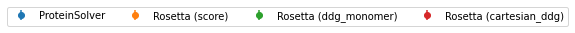

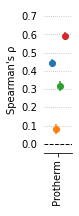

In [61]:
features_to_compare = [
    "scan_sm_log_change",
    #     "ingraham_neglogp_change",
    "rosetta_reu_norm_change",
    "ddg_monomer_soft_rep_design_1",
    "cartesian_ddg_beta_nov16_cart_1",
]

figl, axl = plt.subplots(figsize=(8, 0.35))

fig, ax = plt.subplots(figsize=(1.0, 3))

gp = (
    protherm_correlations_df[protherm_correlations_df["my_wt"] == "protherm"]
    .set_index("feature")
    .loc[features_to_compare]
    .reset_index()
)

width = 0.15  # the width of the bars

labels = gp["label"].unique()
offsets = np.linspace(-width / 2, width / 2, len(labels) + 2)
for j, label in enumerate(labels):
    #     print(label, offsets[j + 1], offsets)
    gp_subset = gp[gp["label"] == label]
    x = np.arange(len(gp_subset))  # the label locations
    x_subset = x + offsets[j + 1]
    #     print(x_subset, gp_subset["corr"].values)
    rects1 = ax.errorbar(
        x_subset,
        gp_subset["corr"].values,
        fmt="o",
        #         width,
        yerr=np.abs(
            gp_subset[["corr_lower_bound", "corr_upper_bound"]].values - gp_subset[["corr"]].values
        ).T,
        label=label,
    )

ax.set_ylabel("Spearman's ρ")

ylim = np.array([-0.05, 0.75])
ax.set_ylim(*ylim)
ax.set_yticks(np.arange(*(ylim + 0.05) * 10) / 10)

ax.set_xticks(x)
ax.set_xticklabels([f"{'Protherm':>9s}"], rotation="vertical")

for tic in ax.yaxis.get_major_ticks():
    tic.tick1line.set_visible(False)
    tic.tick2line.set_visible(False)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.grid(axis="y", linestyle=":")

# ax.set_xlabel(group)
ax.set_xlim(x[0] - 0.1, x[-1] + 0.1)
ax.hlines(0, x[0] - 0.1, x[-1] + 0.1, linestyles="--", linewidth=1)

axl.legend(*ax.get_legend_handles_labels(), ncol=6, bbox_to_anchor=(1.133, 1.25))
axl.axis("off")

fig.subplots_adjust(left=0.56, bottom=0.325, top=1, right=0.95)
fig.savefig(NOTEBOOK_PATH.joinpath("protherm-correlations.pdf"))
fig.savefig(NOTEBOOK_PATH.joinpath("protherm-correlations.svg"))
fig.savefig(NOTEBOOK_PATH.joinpath("protherm-correlations.png"), dpi=300)

figl.savefig(NOTEBOOK_PATH.joinpath("legend.pdf"))
figl.savefig(NOTEBOOK_PATH.joinpath("legend.svg"))
figl.savefig(NOTEBOOK_PATH.joinpath("legend.png"), dpi=300)

None

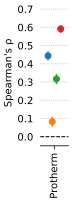

In [62]:
from IPython.display import SVG

display(
    SVG(
        "/home/kimlab1/strokach/workspace/proteinsolver/notebooks/07_protein_analysis_figures/protherm-correlations.svg"
    )
)

### GAPF - Mutations

#### Calculate correlations

In [63]:
feature_columns = [
    "network_score_change",
    "ingraham_neglogp_change",
    "rosetta_score_change",
    "ddg_monomer_change",
    "cartesian_ddg_change",
]
target_column = "consensus_stability_score2_change"

results = []
with concurrent.futures.ProcessPoolExecutor() as pool:
    futures_list = []

    input_dfs = []
    for my_wt, gp in stability_scores_for_mutations["ssm2"].groupby("my_wt"):
        df = gp[feature_columns + [target_column]].dropna()
        print(len(df))
        if df.empty:
            print(f"Skipping {my_wt}!")
            continue
        input_dfs.append(df)

        futures = pool.map(
            compute_ddg_correlation,
            itertools.repeat(my_wt),
            feature_columns,
            itertools.repeat(target_column),
            itertools.repeat(df),
            itertools.repeat(True),
        )
        futures_list.append(futures)

    df = pd.concat(input_dfs, ignore_index=True, sort=False)
    futures = pool.map(
        compute_ddg_correlation,
        itertools.repeat("all"),
        feature_columns,
        itertools.repeat(target_column),
        itertools.repeat(df),
        itertools.repeat(True),
    )
    futures_list.append(futures)

    for futures in futures_list:
        rows = list(tqdm(futures, total=len(feature_columns)))
        results.extend(rows)

correlations_df = pd.DataFrame(results)

774
774
774
774
0
Skipping EHEE_0882.pdb!
0
Skipping EHEE_rd2_0005.pdb!
0
Skipping EHEE_rd3_0015.pdb!
774
774
774
774
0
Skipping HHH_0142.pdb!
774
774
702
828
630


In [64]:
def to_name(s):
    s = s.replace(".pdb", "")
    if "_" in s:
        s1, s2 = s.split("_", 1)
        s2 = s2.replace("_", "-")
        return s1, f"{s2:>9s}"
    else:
        return "Known", f"{s:>9s}"


correlations_df["group"], correlations_df["name"] = list(
    zip(*correlations_df["my_wt"].apply(to_name).values)
)
correlations_df = correlations_df.sort_values("my_wt", ascending=False)

#### Confidence intervals and statistics

In [65]:
columns = [
    "network_score_change",
    "ingraham_neglogp_change",
    "rosetta_score_change",
    "ddg_monomer_change",
    "cartesian_ddg_change",
]

columns_to_save = [
    "group",
    "name",
    "feature_name",
    "corr",
    "pvalue",
    "corr_lower_bound",
    "corr_upper_bound",
    "superior_to_ps",
]

stat_dfs = {}
for (group, name), df in correlations_df[(correlations_df["my_wt"] != "all")].groupby(
    ["group", "name"]
):
    df_ps = df[df["feature"] == "network_score_change"]
    assert len(df_ps) == 1
    corrs_ref = np.array(df_ps.iloc[0]["corrs"])

    df = df.copy()
    df["superior_to_ps_pvalue"] = np.nan
    df.loc[df["feature"] != "network_score_change", "superior_to_ps_pvalue"] = (
        df[df["feature"] != "network_score_change"]["corrs"]
    ).apply(lambda c: compare_correlations(corrs_ref, np.array(c)))

    df["superior_to_ps"] = df["superior_to_ps_pvalue"].apply(
        lambda pvalue: get_superior_to_ps_string(pvalue, cutoff=0.025 / (14 * 4))
    )

    df = df.set_index("feature").reindex(columns, axis=0).reset_index()
    df["feature_name"] = df["feature"].map(LABELS)

    #     display(df[columns_to_save])
    stat_dfs[(group, name)] = df[columns_to_save]

In [66]:
dfs = []
for group in reversed(sorted({k[0] for k in stat_dfs})):
    names = sorted({k[1] for k in stat_dfs if k[0] == group})
    for name in names:
        df = stat_dfs[(group, name)]
        dfs.append(df)
mutation_stat_df = pd.concat(dfs, ignore_index=True, sort=False)

In [67]:
assert len(mutation_stat_df) == (13 * 5)

In [68]:
mutation_stat_df.to_csv(
    NOTEBOOK_PATH.joinpath("rocklin-2017-mutation-stats.csv"), sep="\t", index=False
)

#### Plots

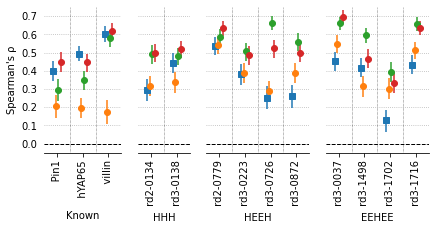

In [69]:
columns = [
    "network_score_change",
    #     "ingraham_neglogp_change",
    "rosetta_score_change",
    "ddg_monomer_change",
    "cartesian_ddg_change",
]

fig, axs = plt.subplots(1, 4, figsize=(6, 3), gridspec_kw={"width_ratios": [3, 2, 4, 4]})

for i, (group, gp) in enumerate(
    sorted(
        correlations_df[correlations_df["my_wt"] != "all"].groupby("group"),
        key=lambda t: t[0],
        reverse=True,
    )
):
    ax = axs[i]
    gp = gp.sort_values("name")

    width = 0.15  # the width of the bars
    offsets = np.linspace(-width, width, len(columns))

    x = None
    x_labels = None
    for column_idx, column in enumerate(columns):
        gp_column = gp[gp["feature"] == column]
        if x is None:
            x = np.arange(len(gp_column))
            x_labels = gp_column["name"].values
        else:
            assert (x_labels == gp_column["name"].values).all()
        rects = ax.errorbar(
            x + offsets[column_idx],
            gp_column["corr"].values,
            fmt="o" if column not in ["network_score_change"] else "s",
            #         width,
            yerr=np.abs(
                (
                    gp_column[["corr_lower_bound", "corr_upper_bound"]].values
                    - gp_column[["corr"]].values
                ).T
            ),
            label=LABELS[column],
        )

    ylim = np.array([-0.05, 0.75])
    ax.set_ylim(*ylim)
    ax.set_yticks(np.arange(*(ylim + 0.05) * 10) / 10)

    ax.vlines(np.arange(0.5, len(x) - 0.5), *ylim, linestyles=":", linewidth=0.5)
    ax.set_xticks(x)
    ax.set_xticklabels(x_labels, rotation="vertical")
    ax.set_xlabel(group)
    ax.set_xlim(x[0] - 0.5, x[-1] + 0.5)
    ax.hlines(0, x[0] - 0.5, x[-1] + 0.5, linestyles="--", linewidth=1)

    if i == 0:
        ax.set_ylabel("Spearman's ρ")

    if i > 0:
        ax.set_yticklabels("")

    for tic in ax.yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.grid(axis="y", linestyle=":")

fig.subplots_adjust(left=0.09, bottom=0.325, top=1, right=0.98)
fig.savefig(NOTEBOOK_PATH.joinpath("gapf-mutation-correlations.pdf"))
fig.savefig(NOTEBOOK_PATH.joinpath("gapf-mutation-correlations.svg"))
fig.savefig(NOTEBOOK_PATH.joinpath("gapf-mutation-correlations.png"), dpi=300)

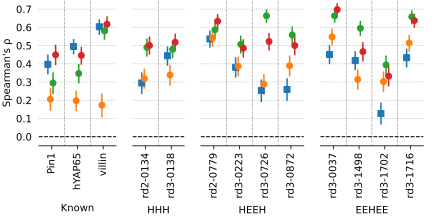

In [70]:
display(
    SVG(
        "/home/kimlab1/strokach/workspace/proteinsolver/notebooks/07_protein_analysis_figures/gapf-mutation-correlations.svg"
    )
)

### GAPF - Stability

#### Calculate correlations

In [71]:
feature_columns = [
    "network_score",
    "structured_transformer_neglogp",
    "talaris2013_score",
    "betanov15_score",
]

In [72]:
stability_scores_for_designs["rd1"].head()

,name,sequence,assay_library,ec50_t,ec50_95ci_lbound_t,ec50_95ci_ubound_t,ec50_95ci_t,ec50_pred_t,ec50_rise_t,stabilityscore_t,ec50_c,ec50_95ci_lbound_c,ec50_95ci_ubound_c,ec50_95ci_c,ec50_pred_c,ec50_rise_c,stabilityscore_c,stabilityscore,talaris2013_score,betanov15_score,library_name,network_score,network_score_wref,sequence_length,domain,identity_to_ref,structured_transformer_neglogp
0,EEHEE_rd1_0001.pdb,GSQEVNSGTQTYKNASPEEAERIARKAGATTWTEKGNKWEIRI,1.0,1.90,1.8,2.0,0.2,1.06,0.84,0.40,0.93,0.7,1.1,0.4,0.57,0.36,0.17,0.17,-78.360,-132.050,rd1,-1.987571,-1.987572,41,EEHEE,1,-2.078434
1,EEHEE_rd1_0002.pdb,GSYELEVGNYRYRADDPEQLKEEAKKVGARDVQTDGNNFKVRG,1.0,0.18,-0.5,0.7,1.2,0.48,-0.30,-0.14,1.08,0.5,1.6,1.1,-0.27,1.35,0.65,-0.14,-78.022,-126.266,rd1,-1.901309,-1.901310,41,EEHEE,1,-1.841325
2,EEHEE_rd1_0003.pdb,GSWRVHFRGETYTADTEDDAKQLAKDAGARRIESSNGEVRVEL,1.0,1.65,1.6,1.7,0.1,1.59,0.06,0.03,1.05,1.0,1.1,0.1,0.91,0.13,0.06,0.03,-73.631,-129.425,rd1,-1.465720,-1.465720,41,EEHEE,1,-1.643996
3,EEHEE_rd1_0004.pdb,GSYTIEENGEKYTFRTRDEAEEWARRQGAQTVETRGTELRSRA,1.0,2.26,2.2,2.4,0.2,1.51,0.74,0.35,-0.30,-0.5,0.1,0.6,0.37,-0.67,-0.32,-0.32,-79.304,-130.277,rd1,-1.953686,-1.953686,41,EEHEE,1,-1.921230
4,EEHEE_rd1_0005.pdb,GSVELEDNGRRVEATSTQEARDRAKKEGATTWTESGTRIEVRG,1.0,0.04,0.0,0.1,0.1,0.95,-0.91,-0.44,0.10,0.1,0.1,0.0,2.56,-2.46,-1.18,-1.18,-71.705,-115.069,rd1,-1.957716,-1.957716,41,EEHEE,1,-2.023995


In [73]:
correlations = []
with concurrent.futures.ProcessPoolExecutor() as pool:
    futures_list = []
    for library in ["rd1", "rd2", "rd3", "rd4"]:
        df = (
            stability_scores_for_designs[library]
            .dropna(
                subset=[
                    "network_score",
                    "talaris2013_score",
                    "betanov15_score",
                    "domain",
                    "stabilityscore_t",
                    "stabilityscore_c",
                ]
            )
            .copy()
        )
        for domain, gp in df.groupby("domain"):
            futures = pool.map(
                compute_stability_correlation,
                itertools.repeat(library),
                itertools.repeat(domain),
                feature_columns,
                itertools.repeat(gp),
                itertools.repeat(True),
            )
            futures_list.append(futures)
    for futures in futures_list:
        results = list(tqdm(futures, total=len(feature_columns)))
        correlations.extend(results)

stability_correlations_df = pd.DataFrame(correlations)

#### Confidence intervals and statistics

In [74]:
columns = [
    "network_score",
    "structured_transformer_neglogp",
    "betanov15_score",
]

columns_to_save = [
    "library",
    "domain",
    "feature_name",
    "corr",
    "pvalue",
    "corr_lower_bound",
    "corr_upper_bound",
    "superior_to_ps",
]

stat_dfs = []
for (library, domain), df in sorted(
    stability_correlations_df[stability_correlations_df["feature"].isin(columns)].groupby(
        ["library", "domain"]
    ),
    key=lambda t: t[0],
):
    df_ps = df[df["feature"] == "network_score"]
    assert len(df_ps) == 1
    corrs_ref = np.array(df_ps.iloc[0]["corrs"])

    df = df.copy()
    df["superior_to_ps_pvalue"] = np.nan
    df.loc[df["feature"] != "network_score", "superior_to_ps_pvalue"] = (
        df[df["feature"] != "network_score"]["corrs"]
    ).apply(lambda c: compare_correlations(corrs_ref, np.array(c)))

    df["superior_to_ps"] = df["superior_to_ps_pvalue"].apply(
        lambda pvalue: get_superior_to_ps_string(pvalue, cutoff=0.025 / (32))
    )

    df = df.set_index("feature").reindex(columns, axis=0).reset_index()
    df["feature_name"] = df["feature"].map(LABELS)

    #     display(df[columns_to_save])
    stat_dfs.append(df[columns_to_save])
stability_stat_df = pd.concat(stat_dfs, ignore_index=True, sort=False)

In [75]:
assert len(stability_stat_df) == (32 + 16)

In [76]:
stability_stat_df.to_csv(
    NOTEBOOK_PATH.joinpath("rocklin-2017-stability-stats.csv"), sep="\t", index=False
)

#### Plots

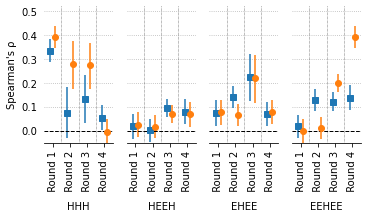

In [77]:
columns = [
    "network_score",
    #     "structured_transformer_neglogp",
    "betanov15_score",
]

fig, axs = plt.subplots(1, 4, figsize=(5, 3))

for i, (domain, gp) in enumerate(
    sorted(stability_correlations_df.groupby("domain"), key=lambda x: x[0], reverse=True)
):
    ax = axs[i]

    gp = gp.sort_values(["domain", "library"])

    width = 0.15  # the width of the bars
    offsets = np.linspace(-width, width, len(columns))

    x = None
    x_labels = None
    for column_idx, column in enumerate(columns):
        gp_column = gp[gp["feature"] == column]
        if x is None:
            x = np.arange(len(gp_column))
            x_labels = gp_column["domain"].values
        else:
            assert (x_labels == gp_column["domain"].values).all()
        rects = ax.errorbar(
            x + offsets[column_idx],
            gp_column["corr"].values,
            fmt="o" if column not in ["network_score"] else "s",
            yerr=np.abs(
                gp_column[["corr_lower_bound", "corr_upper_bound"]].values
                - gp_column[["corr"]].values
            ).T,
            label=LABELS[column],
        )

    ax.set_xticks(x)
    ax.set_xticklabels(["{:>9s}".format(f"Round {i}") for i in range(1, 5)], rotation="vertical")
    ax.set_xlabel(domain)
    ax.set_xlim(x[0] - 0.5, x[-1] + 0.5)
    ax.hlines(0, x[0] - 0.5, x[-1] + 0.5, linestyles="--", linewidth=1)

    if i == 0:
        ax.set_ylabel("Spearman's ρ")

    ax.set_yticks([i / 10 for i in range(0, 7)])
    if i > 0:
        ax.set_yticklabels("")

    for tic in ax.yaxis.get_major_ticks():
        tic.tick1line.set_visible(False)
        tic.tick2line.set_visible(False)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.grid(axis="y", linestyle=":")

    ylim = (-0.05, 0.52)
    ax.vlines(np.arange(0.5, len(x) - 0.5), *ylim, linestyles=":", linewidth=0.5)
    ax.set_ylim(*ylim)


fig.subplots_adjust(left=0.11, bottom=0.325, top=0.955, right=0.99)
fig.savefig(NOTEBOOK_PATH.joinpath("gapf-design-correlations.pdf"))
fig.savefig(NOTEBOOK_PATH.joinpath("gapf-design-correlations.svg"))
fig.savefig(NOTEBOOK_PATH.joinpath("gapf-design-correlations.png"), dpi=300)

In [78]:
NOTEBOOK_PATH.joinpath("gapf-design-correlations.svg")

PosixPath('/home/kimlab1/strokach/workspace/proteinsolver/notebooks/07_protein_analysis_figures/gapf-design-correlations.svg')

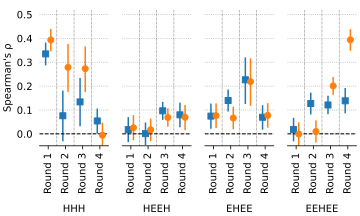

In [79]:
display(
    SVG(
        "/home/kimlab1/strokach/workspace/proteinsolver/notebooks/07_protein_analysis_figures/gapf-design-correlations.svg"
    )
)

array([0, 1, 2, 3])

In [82]:
df.head()

,library,domain,feature,corr,pvalue,corr_lower_bound,corr_upper_bound,corrs
60,rd4,HHH,network_score,0.054155,0.087757,0.001393,0.106113,"[0.008964619974975989, 0.0966365968826762, 0.0..."
63,rd4,HHH,betanov15_score,-0.005729,0.856768,-0.058679,0.047067,"[-0.023431868718727964, 0.014863257613620784, ..."


In [88]:
for library in ["rd1", "rd2", "rd3", "rd4"]:
    df = (
        stability_scores_for_designs[library]
        .dropna(
            subset=[
                "network_score",
                "talaris2013_score",
                "betanov15_score",
                "domain",
                "stabilityscore_t",
                "stabilityscore_c",
            ]
        )
        .copy()
    )
    for domain, gp in df.groupby("domain"):
        corr = stats.spearmanr(gp["structured_transformer_neglogp"].values, -gp["betanov15_score"].values)
        print(library, domain, corr[0], corr[1])

rd1 EEHEE 0.34899306244492756 2.0037519510224867e-33
rd1 EHEE 0.29564298930826216 4.245133344881866e-21
rd1 HEEH 0.3206790705835482 8.369549887417721e-25
rd1 HHH 0.3779533061226832 1.558783143510974e-34
rd2 EEHEE 0.2666546577205308 3.264453857231405e-22
rd2 EHEE 0.09897762454063767 0.0005110956648066311
rd2 HEEH 0.23731918161905038 2.10201757592886e-16
rd2 HHH 0.32567179241476046 2.934280705208118e-07
rd3 EEHEE 0.18941058827682467 3.956721977334584e-16
rd3 EHEE -0.02729670847024413 0.667547801898891
rd3 HEEH 0.14173880216032186 1.3617763585229958e-09
rd3 HHH 0.40430762980333873 3.0001162759095446e-11
rd4 EEHEE 0.31357420442860806 3.4606316280145486e-24
rd4 EHEE 0.08534899287110768 0.006923006301084212
rd4 HEEH 0.027663605609201357 0.3836225901528332
rd4 HHH 0.05892633026014195 0.0631650344423589


In [93]:
[
    tuple(t.split("\t"))
    for t in """\
rd1	EEHEE
rd1	EHEE
rd1	HEEH
rd2	HEEH
rd4	EHEE
rd4	HEEH
rd4	HHH""".split(
        "\n"
    )
]

[('rd1', 'EEHEE'),
 ('rd1', 'EHEE'),
 ('rd1', 'HEEH'),
 ('rd2', 'HEEH'),
 ('rd4', 'EHEE'),
 ('rd4', 'HEEH'),
 ('rd4', 'HHH')]

In [111]:
corrs = []
for library in ["rd1", "rd2", "rd3", "rd4"]:
    df = (
        stability_scores_for_designs[library]
        .dropna(
            subset=[
                "network_score",
                "talaris2013_score",
                "betanov15_score",
                "domain",
                "stabilityscore_t",
                "stabilityscore_c",
            ]
        )
        .copy()
    )
    for domain, gp in df.groupby("domain"):
        corr_ref_1 = stats.spearmanr(-gp["network_score"].values, gp["stabilityscore"].values)
        corr_ref_2 = stats.spearmanr(gp["betanov15_score"].values, gp["stabilityscore"].values)
        cutoff = 0.05 / 48
        if corr_ref_1.pvalue < cutoff or corr_ref_2.pvalue < cutoff:
            continue

        corr = stats.spearmanr(-gp["network_score"].values, gp["betanov15_score"].values)
        print(library, domain, corr[0], corr[1])
        corrs.append(corr[0])

rd1 EEHEE 0.3699225074142357 1.2061200642877184e-37
rd1 EHEE 0.239320846107136 3.742853452264722e-14
rd1 HEEH 0.35408372524226034 3.1136789518447738e-30
rd2 EHEE 0.09278284853837114 0.0011282913532033685
rd2 HEEH 0.2768466669824241 5.618170662577158e-22
rd4 EHEE 0.07521742359742871 0.017360638699670312
rd4 HEEH 0.13127749394540897 3.300757736602212e-05
rd4 HHH 0.07841797647755214 0.01335018119380296


In [112]:
np.mean(corrs)

0.20223368603810213

In [119]:
(1 - 0.025 / (32)) * 100

99.921875

In [116]:
1 - 0.00044642857142857147

0.9995535714285714

In [120]:
feature_columns = [
    "scan_sm_log_change",
    "ingraham_neglogp_change",
    "rosetta_reu_change",
    "rosetta_reu_norm_change",
    "ddg_monomer_soft_rep_design_1",
    "cartesian_ddg_beta_nov16_cart_1",
]

df = protherm_wresults_df[~protherm_wresults_df["has_homologs"].astype(np.bool)].dropna(
    subset=feature_columns
)

In [122]:
len(df)

179

In [124]:
len(df["structure_id"].unique())

9